In [108]:
#input convolutional network accepts 2-dim and 3-dim -
#kernel size - 3x3
#sliding window principle 
#polling principle - e.g  max pooling  
#multiple layers - 3-4-5. 
#cats vs dogs 

#cats vs dogs microsoft datasets
#https://www.microsoft.com/en-us/download/details.aspx?id=54765

import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F


#flag for preprocessing / alternative seperate
REBUILD_DATA = False



In [109]:


class DogsVSCats():
    IMG_SIZE=50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1} # we should one hot encode this
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            
            #list over directory
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                        
                    if label == self.CATS:
                        self.catcount +=1
                    elif label == self.DOGS:
                        self.dogcount +=1
                except Exception as e:
                    #print(e)
                    pass
                
        
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats:", self.catcount)
        print("Dogs:",self.dogcount)


In [110]:
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()




In [111]:
REBUILD_DATA = False

training_data = np.load("training_data.npy", allow_pickle=True)

In [112]:
print(len(training_data))

24946


In [113]:
print(training_data[0])

[array([[ 76,  77,  69, ..., 195, 191, 191],
       [ 75,  73,  70, ..., 193, 193, 191],
       [ 77,  71,  71, ..., 192, 191, 192],
       ...,
       [ 73,  69,  69, ..., 190, 204, 209],
       [ 70,  68,  66, ..., 182, 205, 219],
       [ 65,  66,  62, ..., 177, 208, 238]], dtype=uint8)
 array([1., 0.])]


(24946, 2)
[1. 0.]


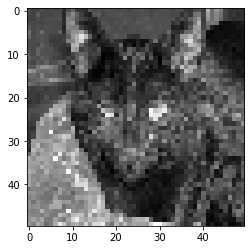

In [114]:
import matplotlib.pyplot as plt

print(training_data.shape)
plt.imshow(training_data[2][0], cmap="gray")
print(training_data[2][1])

In [115]:

class Net (nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,5)
        self.conv2 = nn.Conv2d(32,64,5)
        self.conv3 = nn.Conv2d(64,128,5)
        
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear,512)
        self.fc2 = nn.Linear(512,2)
        
    def convs(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2)) 
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2)) 
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2)) 
        
      #  print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
        
        
     

In [116]:
device = torch.device("cuda:0")
device

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print ("running on the CPU")
    
torch.cuda.device_count()

running on the GPU


1

In [117]:
net = Net().to(device)

In [118]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr =0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
#print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))


22452
2494


In [119]:


def train(net):
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    BATCH_SIZE = 100
    EPOCHS = 5

    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            #print(i, i+BATCH_SIZE)
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            net.zero_grad()
            optimizer.zero_grad()   # zero the gradient buffers
            
            outputs = net(batch_X)
            loss = loss_function(outputs,batch_y)
            loss.backward()
            optimizer.step()
            
        print(f"Epoche :{epoch}. Loss:{loss}")
        
#train(net)

  5%|▌         | 12/225 [00:00<00:01, 117.88it/s]

Epoche :0. Loss:0.23214152455329895


  5%|▌         | 12/225 [00:00<00:01, 116.78it/s]

Epoche :1. Loss:0.20911255478858948


  5%|▌         | 12/225 [00:00<00:01, 117.57it/s]

Epoche :2. Loss:0.20062516629695892


  5%|▌         | 12/225 [00:00<00:01, 118.48it/s]

Epoche :3. Loss:0.19448335468769073


100%|██████████| 225/225 [00:02<00:00, 111.24it/s]

Epoche :4. Loss:0.15278910100460052


In [120]:
def fwd_pass(X,y, train=False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs,y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)
    
    if train:
        loss.backward()
        optimizer.step()
    return acc, loss

def test(size=32):
    random_start = np.random.randint(len(test_X) - size)
    X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
    with torch.no_grad():
        val_acc, val_loss = fwd_pass(X.view(-1,1,50,50).to(device), y.to(device))
    return val_acc, val_loss

val_acc, val_loss = test(size=320)
print(val_acc,val_loss)
    
    

0.7625 tensor(0.1690, device='cuda:0')


In [128]:
import time

MODEL_NAME = f"model-{int(time.time())}"

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr =0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)

def train():
    BATCH_SIZE = 100
    EPOCHS =30
    
    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                #print(i, i+BATCH_SIZE)
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50).to(device)
                batch_y = train_y[i:i+BATCH_SIZE].to(device)
                
                acc, loss = fwd_pass(batch_X, batch_y, train=True)
                if i%100 == 0:
                    val_acc, val_loss = test(size=100)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss),4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")
                    
train()

  2%|▏         | 4/225 [00:00<00:06, 32.49it/s]

model-1632929827


100%|██████████| 225/225 [00:05<00:00, 41.74it/s]


In [ ]:
test_X.to(device)
test_y.to(device)

def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i].to(device))
            net_out = net(test_X[i].view(-1,1,50,50).to(device))[0]
            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct +=1
            total +=1

    print(correct)
    print(total)
    print("accuracy", round(correct/total,3))

test(net)